In [20]:
# start with imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, plot_roc_curve, plot_confusion_matrix 

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import nltk
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from collections import Counter

cv = StratifiedKFold(n_splits=3,
                     random_state=73,
                     shuffle=True)

In [2]:
# loading backup data
# df = pd.read_csv('./data/backup_data.csv')
df = pd.read_csv('./data/reddit_scrap.csv')

In [3]:
# Binary target
comment_median = df['num_comments'].median()
df['target'] = [1 if x>comment_median else 0 for x in df['num_comments']]
comment_median

105.0

In [4]:
# Baseline accuracy
1 - df['target'].mean()

0.5006873977086743

## Feature Engineering 

In [5]:
# Load language model
nlp = spacy.load('en_core_web_sm')

# Stem the thread titles
stemmer = PorterStemmer()
df['stemmed_text'] = [' '.join([stemmer.stem(w.text) for w in nlp(t)]) for t in df.title]

In [6]:
# Vectorize stemmed thread titles
tvec = TfidfVectorizer(stop_words='english', 
                       strip_accents='ascii',
                       max_features=100, 
                       max_df=.60, 
                       norm='l2')
tvec.fit(df.stemmed_text)

df_tvec = pd.DataFrame(tvec.transform(df['title']).todense(), 
                     columns=tvec.get_feature_names())

C:\Users\Dimitrios\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
# Count parts of speech
pos_for_df = [Counter([w.pos_ for w in nlp(t)]) for t in df.title]

# Get all parts of speech
all_pos = list(set([key for pos_counter in pos_for_df for key in pos_counter]))

In [8]:
# parse thread titles
for pos in all_pos:
    df_tvec[pos + '_proportion'] = 0
    
parsed_quotes = []

for i, parsed in enumerate(nlp.pipe(df.title.values,
                                       batch_size = 50,
                                       n_process = 8)): 
    assert parsed.is_parsed
    parsed_quotes.append(parsed) 

<ipython-input-8-acdc8506902c>:10: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  assert parsed.is_parsed


In [9]:
# Add proportions from Parts of Speech
for i, parsed in enumerate(parsed_quotes):
    parsed_len = len(parsed)
    for pos in all_pos:
        count = len([x for x in parsed if x.pos_ == pos])
        df_tvec.loc[i, pos+'_proportion'] = float(count) / parsed_len

In [10]:
# X and y
X = df_tvec
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42,
                                                    stratify = y)

## Random Forest Model

In [11]:
# RandomForest gridsearch
rt_params = {
    'n_estimators':[100,150,200],
    'class_weight':['balanced','balanced_subsample']
}
rt_gridsearch = GridSearchCV(RandomForestClassifier(), 
                             rt_params, 
                             cv=5, 
                             verbose=1)
rt_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [12]:
def grid_values(gridsearch):
    return f'Best Score: {gridsearch.best_score_}, Test Score: {gridsearch.score(X_test, y_test)}'

In [13]:
grid_values(rt_gridsearch)

'Best Score: 0.5980065718565805, Test Score: 0.6026582027375521'

In [14]:
pred_rt = rt_gridsearch.predict(X_test)
f'Accuracy: {accuracy_score(y_test, pred_rt)}, Recall (Sensitivity): {recall_score(y_test, pred_rt)}, Precision: {precision_score(y_test, pred_rt)}'

'Accuracy: 0.6026582027375521, Recall (Sensitivity): 0.6261422328168454, Precision: 0.5974222896133434'

## Logistic Regression Model

In [15]:
logreg_params = {
    'penalty':['l2','none'],
    'class_weight':['balanced'],
    'random_state':[42],
    'solver':['sag'],
    'max_iter':[2000],
    'n_jobs':[1]
}
logreg_gridsearch = GridSearchCV(LogisticRegression(),
                                logreg_params,
                                cv=5,
                                verbose=1)
logreg_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\Dimitrios\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Dimitrios\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Dimitrios\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Dimitrios\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'class_weight': ['balanced'], 'max_iter': [2000],
                         'n_jobs': [1], 'penalty': ['l2', 'none'],
                         'random_state': [42], 'solver': ['sag']},
             verbose=1)

In [16]:
grid_values(logreg_gridsearch)

'Best Score: 0.5578464252337898, Test Score: 0.5524697480658599'

In [17]:
pred_log = logreg_gridsearch.predict(X_test)
f'Accuracy: {accuracy_score(y_test, pred_log)}, Recall (Sensitivity): {recall_score(y_test, pred_log)}, Precision: {precision_score(y_test, pred_log)}'

'Accuracy: 0.5524697480658599, Recall (Sensitivity): 0.5212554628526023, Precision: 0.5552264071096065'

### Summary Metrics

| Metrics    | Random Forest Model | Logistic Regression Model|
| ----------- | ----------- | ----------- |
| Best Score  | **0.571**   | 0.565 |
| Test Score  | **0.573**       | 0.565
| Accuracy  | **0.573**       | 0.565
| Sensitivity  | **0.603**       | 0.523
| Precision  | 0.568        | **0.570**

## Confusion Matricies

### Random Forest

In [18]:
cm_rt = confusion_matrix(y_test, pred_rt)
cm_df_rt = pd.DataFrame(cm_rt, columns=['pred low comments/pred_neg', 'pred high comments/pred_pos'], 
                     index=['actual low comments/actual_neg', 'actual high comments/actual_pos'])
cm_df_rt

,pred low comments/pred_neg,pred high comments/pred_pos
actual low comments/actual_neg,1462,1062
actual high comments/actual_pos,941,1576


C:\Users\Dimitrios\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


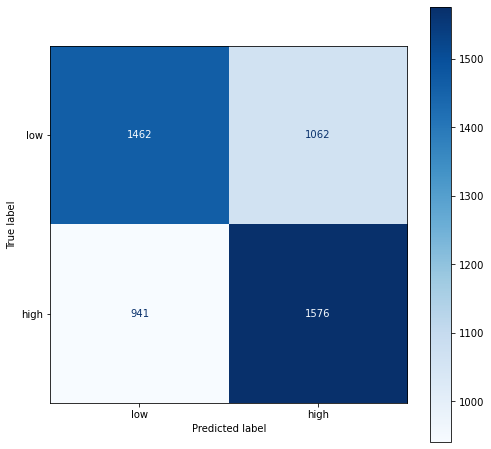

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rt_gridsearch, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['low', 'high'], ax=ax);

### Logistic Regression

In [22]:
cm_log = confusion_matrix(y_test, pred_log)
cm_df_log = pd.DataFrame(cm_log, columns=['pred low comments/pred_neg', 'pred high comments/pred_pos'], 
                     index=['actual low comments/actual_neg', 'actual high comments/actual_pos'])
cm_df_log

,pred low comments/pred_neg,pred high comments/pred_pos
actual low comments/actual_neg,1473,1051
actual high comments/actual_pos,1205,1312


C:\Users\Dimitrios\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


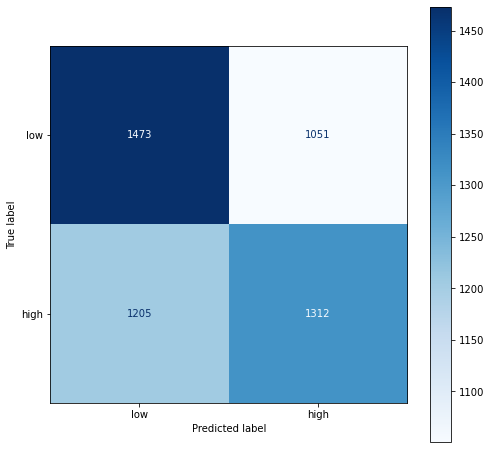

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(logreg_gridsearch, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['low', 'high'], ax=ax);